# Implementing a Differentially Private ANN with TensorFlow Privacy, for Bank Customer Churn Prediction

## Importing Libraries

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import numpy as np
import pandas as pd

Install TensorFlow Privacy.

In [3]:
!pip install tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

     |████████████████████████████████| 251 kB 5.3 MB/s 
     |████████████████████████████████| 4.0 MB 34.1 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


## Load pre-processed Churn Modelling Dataset and Create Test and Train Datasets with Split




In [4]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df=pd.get_dummies(df, columns=['Geography','Gender'])

In [6]:
# Dropping columns which either don't help in prediction or can be used to identify individuals from Dataset 

df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


### Load the created Training Dataset

In [7]:
X = df.loc[:, df.columns != 'Exited']

In [8]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


In [11]:
y = df["Exited"].astype('float')

In [12]:
y.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: Exited, dtype: float64

Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 1, stratify=y)


In [14]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
861,548,32,2,172448.77,1,1,0,188083.77,1,0,0,1,0
3285,735,43,9,98807.45,1,0,0,184570.04,0,1,0,1,0
7532,760,33,1,118114.28,2,0,1,156660.21,0,0,1,1,0
1845,737,36,9,0.00,1,0,1,188670.90,1,0,0,0,1
8051,605,56,1,74129.18,2,1,1,62199.78,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6738,573,35,9,134498.54,2,1,1,119924.80,0,1,0,0,1
6278,602,72,3,0.00,2,1,1,171260.66,1,0,0,1,0
3361,602,48,7,76595.08,2,0,0,127095.14,0,1,0,1,0
9357,418,46,9,0.00,1,1,1,81014.50,1,0,0,1,0


In [15]:
# Scaling data

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
#X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
# For final test scale and predict with train scaler

## Defining model hyperparameters




In [16]:
epochs = 100
batch_size = 128

In [17]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 64
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

## Building our DP ANN


In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
callback = keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True)
# initializing ann
model = Sequential()

# adding the first input layer and the first hidden layer
model.add(Dense(18, kernel_initializer = 'normal', activation = 'relu', input_shape = (13, )))

# adding batch normalization and dropout layer
model.add(Dropout(rate = 0.1))
model.add(BatchNormalization())

# adding the third hidden layer
model.add(Dense(14, kernel_initializer = 'normal', activation = 'relu'))

# adding batch normalization and dropout layer
model.add(Dropout(rate = 0.1))
model.add(BatchNormalization())

model.add(Dense(10, kernel_initializer = 'normal', activation = 'relu'))

# adding batch normalization and dropout layer
model.add(Dropout(rate = 0.1))
model.add(BatchNormalization())

model.add(Dense(6, kernel_initializer = 'normal', activation = 'relu'))

# adding batch normalization and dropout layer
model.add(Dropout(rate = 0.05))
model.add(BatchNormalization())

# adding the output layer
model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid'))


Define the optimizer and loss function for the learning model. 
We compute the loss by using a vector of losses per-example, so we can support gradient manipulation over each training point. 

This is different compared to the standard mean over a minibatch

In [39]:
optimizer = DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    learning_rate=learning_rate)

loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)

## Compiling and training the DP ANN Model


In [40]:
import time, datetime #Used for training time

In [41]:
model.compile(optimizer=optimizer, loss = loss, metrics=['accuracy'])


start = datetime.datetime.now()
model_history = model.fit(X_train, y_train,
          epochs=epochs,
          validation_split=0.1,
          batch_size = batch_size, callbacks = [callback])
end = datetime.datetime.now()
print("Overall Training Time: ", (end - start))

Epoch 1/100
70/70 [==============================] - 9s 43ms/step - loss: 0.5793 - accuracy: 0.7175 - val_loss: 0.5234 - val_accuracy: 0.7889
Epoch 2/100
70/70 [==============================] - 3s 41ms/step - loss: 0.5791 - accuracy: 0.7744 - val_loss: 0.5408 - val_accuracy: 0.7889
Epoch 3/100
70/70 [==============================] - 3s 40ms/step - loss: 0.6255 - accuracy: 0.8067 - val_loss: 0.6497 - val_accuracy: 0.7889
Epoch 4/100
70/70 [==============================] - 3s 40ms/step - loss: 0.6387 - accuracy: 0.8159 - val_loss: 0.6442 - val_accuracy: 0.7970
Epoch 5/100
70/70 [==============================] - 3s 42ms/step - loss: 0.6523 - accuracy: 0.8263 - val_loss: 0.5962 - val_accuracy: 0.8222
Epoch 6/100
70/70 [==============================] - 3s 42ms/step - loss: 0.6116 - accuracy: 0.8354 - val_loss: 0.6108 - val_accuracy: 0.8131
Epoch 7/100
70/70 [==============================] - 3s 43ms/step - loss: 0.6283 - accuracy: 0.8370 - val_loss: 0.5989 - val_accuracy: 0.8232
Epoch 

In [21]:
acc = model.evaluate(X_test, y_test)[1]

print(f'Accuracy of model is {acc}')

4/4 [==============================] - 0s 3ms/step - loss: 0.3476 - accuracy: 0.9000
Accuracy of model is 0.8999999761581421


In [22]:
threshold = 0.5
y_prob = model.predict(X_test)
y_pred = np.where(y_prob >= threshold, 1,0)

In [28]:
 from sklearn.metrics import confusion_matrix
 from sklearn.metrics import precision_recall_fscore_support
 import matplotlib.pyplot as plt
 import seaborn as sns

Text(0.5, 1.0, 'Churn Modelling Confusion Matrix')

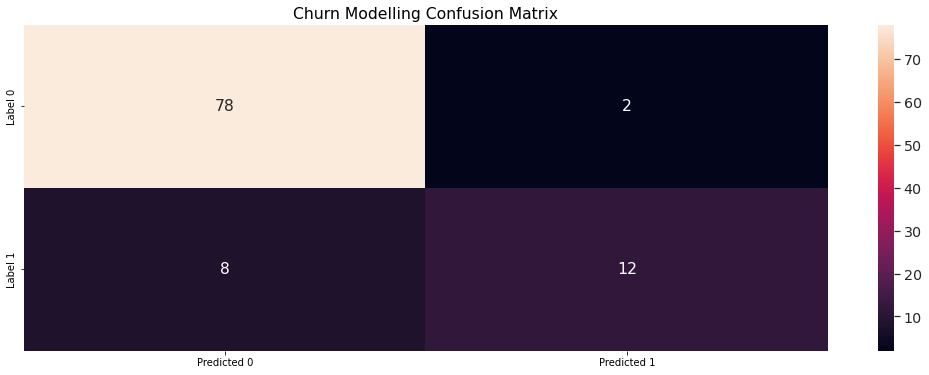

In [29]:
# Confusion Matrix for Basic Logistic Regression Model
conf_Log = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(figsize=(18,6))

new_conf = pd.DataFrame(conf_Log, index = ['Label 0','Label 1'],columns = ['Predicted 0','Predicted 1'])


sns.set(font_scale=1.3)
sns.heatmap(new_conf.iloc[-1::-1,:], annot=True,fmt= 'g', ax = axes)
axes.set_ylim([0,2]);
axes.set_title('Churn Modelling Confusion Matrix')

In [30]:
# Precision: Whenever Model Predicts True, how many times it is actually true
# Recall: Out of all True, how many did the Model find out

# Precision:   True Positives/(True Positives + False Positives)
# Recall:   True Positives/(True Positives + False Negatives)

TP = conf_Log[1][1] 
FP = conf_Log[0][1]
TN = conf_Log[0][0]
FN = conf_Log[1][0]

In [31]:
Precision_Metric = TP/(TP + FP)
print("Precision is:", Precision_Metric)

Precision is: 0.8571428571428571


In [32]:
Recall_Metric = TP/(TP + FN)
print("Recall is:", Recall_Metric)

Recall is: 0.6


In [33]:
F1_Metric = (2*Precision_Metric*Recall_Metric)/(Precision_Metric + Recall_Metric)
print("F1 Score is:", F1_Metric)

F1 Score is: 0.7058823529411764


In [34]:
model.save_weights("Model_DP_ANN_Tensorflow_Privacy.h5")

In [48]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=9900, batch_size=128, noise_multiplier=1.3, epochs=30, delta=1e-5)

DP-SGD with sampling rate = 1.29% and noise_multiplier = 1.3 iterated over 2321 steps satisfies differential privacy with eps = 2.58 and delta = 1e-05.
The optimal RDP order is 8.0.


(2.5776593476915757, 8.0)

In [47]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=9900, batch_size=128, noise_multiplier=1.3, epochs=100, delta=1e-5)

DP-SGD with sampling rate = 1.29% and noise_multiplier = 1.3 iterated over 7735 steps satisfies differential privacy with eps = 4.97 and delta = 1e-05.
The optimal RDP order is 5.0.


(4.968762552641338, 5.0)